# 텐서플로(simpleRNN)로 순환신경망 만들기

## 순환 신경망에 필요한 클래스 임포트하기

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

## 데이터불러오기

In [7]:
import numpy as np
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

word_to_index = imdb.get_word_index()
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=' ')

np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

from tensorflow.keras.preprocessing import sequence
maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

from tensorflow.keras.utils import to_categorical
x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

## 모델만들기

simpleRNN클래스를 사용하는 방법은 Dense클래스와 다르지 않습니다. 사용할 셀의 개수를 지정하고 Sequential 모델의 첫번째 층이므로 입력 차원을 지정합니다. 타임 스텝의 길이가 100이고 원핫인코딩 크기가 100이므로 입력크기는 (100,100)입니다. 이진 분류이므로 1개의 유닛을 가진 Dense층을 마지막에 추가합니다.

In [3]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


입력은 원핫 인코딩된 100차원의 벡터이고 셀 개수가 32개 이므로 W1x행렬 요소의 개수는 100*32가 될 것입니다. 또한 W1h행렬의 요소 개수도 32*32가 될 것입니다. 마지막으로 셀마다 하나씩 총 32개의 절편이 있습니다. 따라서 순환층에 필요한 전체 파라미터 개수는 4256개 입니다.

## 모델 컴파일하고 훈련시키기

In [8]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 30s 46ms/step - loss: 0.6986 - accuracy: 0.5252 - val_loss: 0.6861 - val_accuracy: 0.5556
Epoch 2/20
625/625 [==============================] - 28s 45ms/step - loss: 0.6756 - accuracy: 0.5829 - val_loss: 0.6574 - val_accuracy: 0.6134
Epoch 3/20
625/625 [==============================] - 28s 45ms/step - loss: 0.6592 - accuracy: 0.6116 - val_loss: 0.6435 - val_accuracy: 0.6280
Epoch 4/20
625/625 [==============================] - 28s 45ms/step - loss: 0.6400 - accuracy: 0.6397 - val_loss: 0.6138 - val_accuracy: 0.6696
Epoch 5/20
625/625 [==============================] - 28s 44ms/step - loss: 0.6267 - accuracy: 0.6542 - val_loss: 0.6722 - val_accuracy: 0.5728
Epoch 6/20
625/625 [==============================] - 28s 45ms/step - loss: 0.6166 - accuracy: 0.6635 - val_loss: 0.6360 - val_accuracy: 0.6352
Epoch 7/20
625/625 [==============================] - 28s 45ms/step - loss: 0.6006 - accuracy: 0.6812 - val_loss: 0.5935 - val_accuracy:

## 훈련,검증 세트에 대한 손실 그래프와 정확도그래프 그리기 

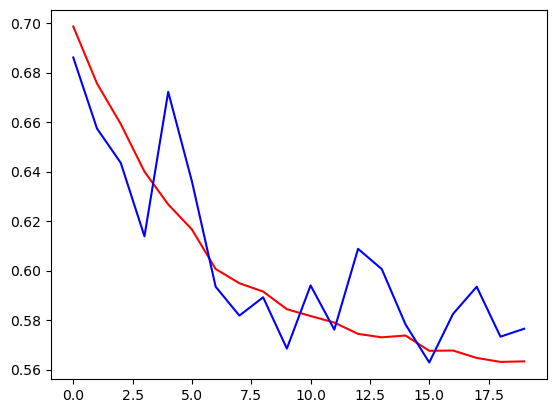

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'],color='b')
plt.show()

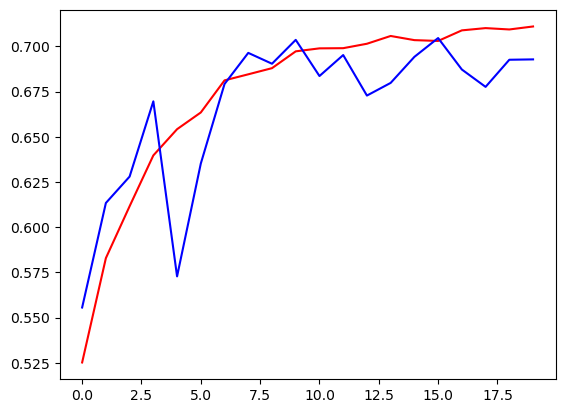

In [21]:
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.show()

## 검증 세트 정확도 평가하기

In [22]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)
print(accuracy)

0.692799985408783


예측 확률 69% 성능이 나왔지만 조금 더 높혀보기 위해 아래 임베딩층을 이용해 보겠습니다.

# 임베딩층으로 순환 신경망 모델 성능 높이기

## 훈련데이터 준비하기

단어 임베딩은 단어를 표현하는 벡터의 크기를 임의로 지정할 수 있으므로 사용하는 단어의 개수에 영향을 받지 않습니다.

In [23]:
from tensorflow.keras.layers import Embedding

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

## 샘플 길이 맞추기

In [24]:
maxlen=100  #타임 스텝의 길이가 100인 시퀀스 데이터를 만듭니다.
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

## 모델 만들기

원핫인코딩된 입력 벡터의 길이는 100이었지만 단어 임베딩에서는 길이를 32로 줄이겠습니다. Embedding 클래스에 입력한 매개변수는 단어 개수와 출력 길이 입니다. 또한 SimpleRNN의 셀 개수를 8개로 크게 줄이겟습니다. 임베딩층의 성능이 뛰어나기 때문에 셀 개수가 적어도 만족할 만한 성능을 얻을 수 있을 것입니다.

In [25]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 328       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


## 모델 컴파일하고 훈련시키기

In [26]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                        validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 84s 134ms/step - loss: 0.5912 - accuracy: 0.6709 - val_loss: 0.5005 - val_accuracy: 0.7692
Epoch 2/10
625/625 [==============================] - 84s 134ms/step - loss: 0.4503 - accuracy: 0.8033 - val_loss: 0.4733 - val_accuracy: 0.7900
Epoch 3/10
625/625 [==============================] - 84s 135ms/step - loss: 0.4005 - accuracy: 0.8291 - val_loss: 0.4578 - val_accuracy: 0.8036
Epoch 4/10
625/625 [==============================] - 84s 134ms/step - loss: 0.3465 - accuracy: 0.8579 - val_loss: 0.4509 - val_accuracy: 0.8032
Epoch 5/10
625/625 [==============================] - 84s 135ms/step - loss: 0.3054 - accuracy: 0.8799 - val_loss: 0.4495 - val_accuracy: 0.8114
Epoch 6/10
625/625 [==============================] - 84s 134ms/step - loss: 0.2742 - accuracy: 0.8927 - val_loss: 0.4705 - val_accuracy: 0.8148
Epoch 7/10
625/625 [==============================] - 84s 135ms/step - loss: 0.2634 - accuracy: 0.8964 - val_loss: 0.4883 - val_ac

## 손실 그래프와 정확도 그래프 그리기

훈련 초기에 이미 성능이 크게 향상되어 에포크가 진행됨에 따라 다소 과대적합되는 모습을 보입니다.

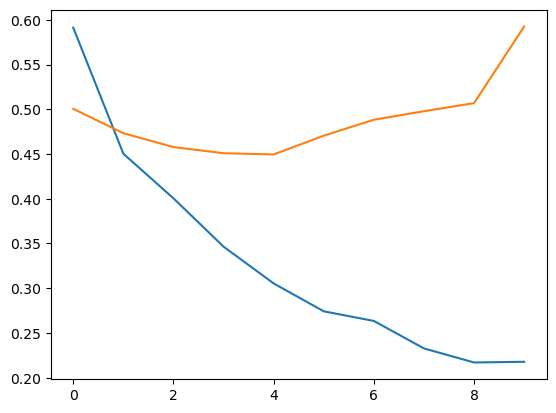

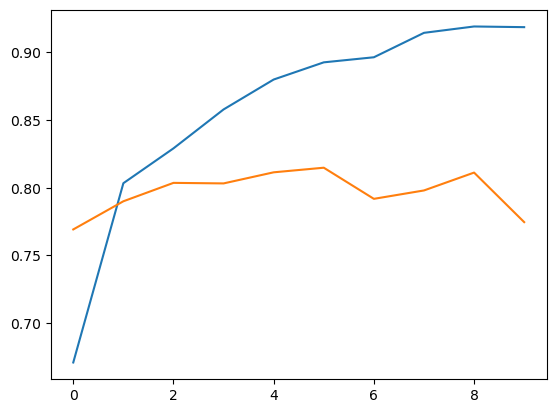

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

## 검증 세트 정확도 평가하기

원핫인코딩을 사용하지 않아 메모리 사용량이 절감되었습니다. 또한 적은 셀 개수에서도 더 높은 성능을 내었습니다.

In [28]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.7746000289916992
